In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from captum.attr import LayerConductance

# Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG16 model
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
model.eval()

# Prepare ImageNet dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load a subset of ImageNet for demonstration
class ILSVRC2017Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(root, file))
                    self.labels.append(os.path.basename(os.path.dirname(os.path.join(root, file))))

        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load ILSVRC2017 dataset
imagenet_data = ILSVRC2017Dataset(root_dir='../data', transform=transform)
dataloader = torch.utils.data.DataLoader(imagenet_data, batch_size=1, shuffle=True)

# Function to resample a tensor
def resample_tensor(tensor, new_size):
    x = np.arange(len(tensor))
    f = interp1d(x, tensor.numpy(), kind='linear')
    x_new = np.linspace(0, len(tensor) - 1, new_size)
    resampled_tensor = f(x_new)
    return torch.tensor(resampled_tensor)

# Function to compute mutual information
def mutual_information(x, y, num_bins=200):
    x = torch.tensor(x) if not isinstance(x, torch.Tensor) else x
    y = torch.tensor(y) if not isinstance(y, torch.Tensor) else y
    
    x = x.flatten()
    y = y.flatten()
    if len(x) != len(y):
        max_len = max(len(x), len(y))
        x = resample_tensor(x, max_len)
        y = resample_tensor(y, max_len)
    x_np = x.numpy()
    y_np = y.numpy()
    joint_hist, x_edges, y_edges = np.histogram2d(x_np, y_np, bins=num_bins)
    
    x_hist = np.histogram(x_np, bins=x_edges)[0]
    y_hist = np.histogram(y_np, bins=y_edges)[0]
    
    p_xy = joint_hist / joint_hist.sum()
    p_x = x_hist / x_hist.sum()
    p_y = y_hist / y_hist.sum()
    
    p_xy = p_xy + 1e-9
    p_x = p_x + 1e-9
    p_y = p_y + 1e-9
    
    mi = np.sum(p_xy * (np.log(p_xy) - np.log(p_x[:, None]) - np.log(p_y[None, :])))
    
    return max(0, mi)

# Function to predict image class
def predict_image_class(model, input_data):
    with torch.no_grad():
        output = model(input_data)
    _, predicted_idx = torch.max(output, 1)
    return predicted_idx.item()

# Modified Function to get layer conductance
def get_layer_conductance(model, layer_index, input_data):
    layers = [
        model.features[0], model.features[2], model.features[5], model.features[7],
        model.features[10], model.features[12], model.features[14], model.features[17],
        model.features[19], model.features[21], model.features[24], model.features[26],
        model.features[28], model.classifier[0], model.classifier[3], model.classifier[6]
    ]
    class_idx = predict_image_class(model, input_data)
    cond = LayerConductance(model, layers[layer_index])
    conductance = cond.attribute(input_data, target=class_idx)
    return conductance

# Select random samples
num_samples = 100
random_samples = []
random_labels = []

for i, (data, target) in enumerate(dataloader):
    if i >= num_samples:
        break
    random_samples.append(data.to(device))
    random_labels.append(target.item())

# Calculate mutual information for each layer
layers = list(range(16))  # VGG16 has 16 main layers
mi_x_t = []
mi_t_y = []

model.eval()
with torch.no_grad():
    for layer in tqdm(layers, desc="Calculating MI"):
        layer_mi_x_t = []
        layer_mi_t_y = []
        
        for sample, label in zip(random_samples, random_labels):
            conductance = get_layer_conductance(model, layer, sample)
            conductance = conductance.cpu().numpy().flatten()
            
            mi_x_t_sample = mutual_information(sample.cpu().numpy().flatten(), conductance)
            mi_t_y_sample = mutual_information(conductance, np.array([label]))
            
            layer_mi_x_t.append(mi_x_t_sample)
            layer_mi_t_y.append(mi_t_y_sample)
        

        mi_x_t.append(layer_mi_x_t)
        mi_t_y.append(layer_mi_t_y) 
        


Calculating MI: 100%|██████████| 16/16 [2:33:38<00:00, 576.17s/it]  


In [3]:
num_samples = 100

In [4]:
import pickle
# Save the mutual information to a file
#with open("mutual_info_CIP_VGG16.pkl", "wb") as f:
#    pickle.dump({"mi_x_t": mi_x_t, "mi_t_y": mi_t_y}, f)


In [5]:
# Load mutual information data
with open("mutual_info_CIP_VGG16.pkl", "rb") as f:
    data = pickle.load(f)
    mi_x_t = data["mi_x_t"]
    mi_t_y = data["mi_t_y"]

# Exclude the last layer's results
mi_x_t = mi_x_t[:-1]  
mi_t_y = mi_t_y[:-1]

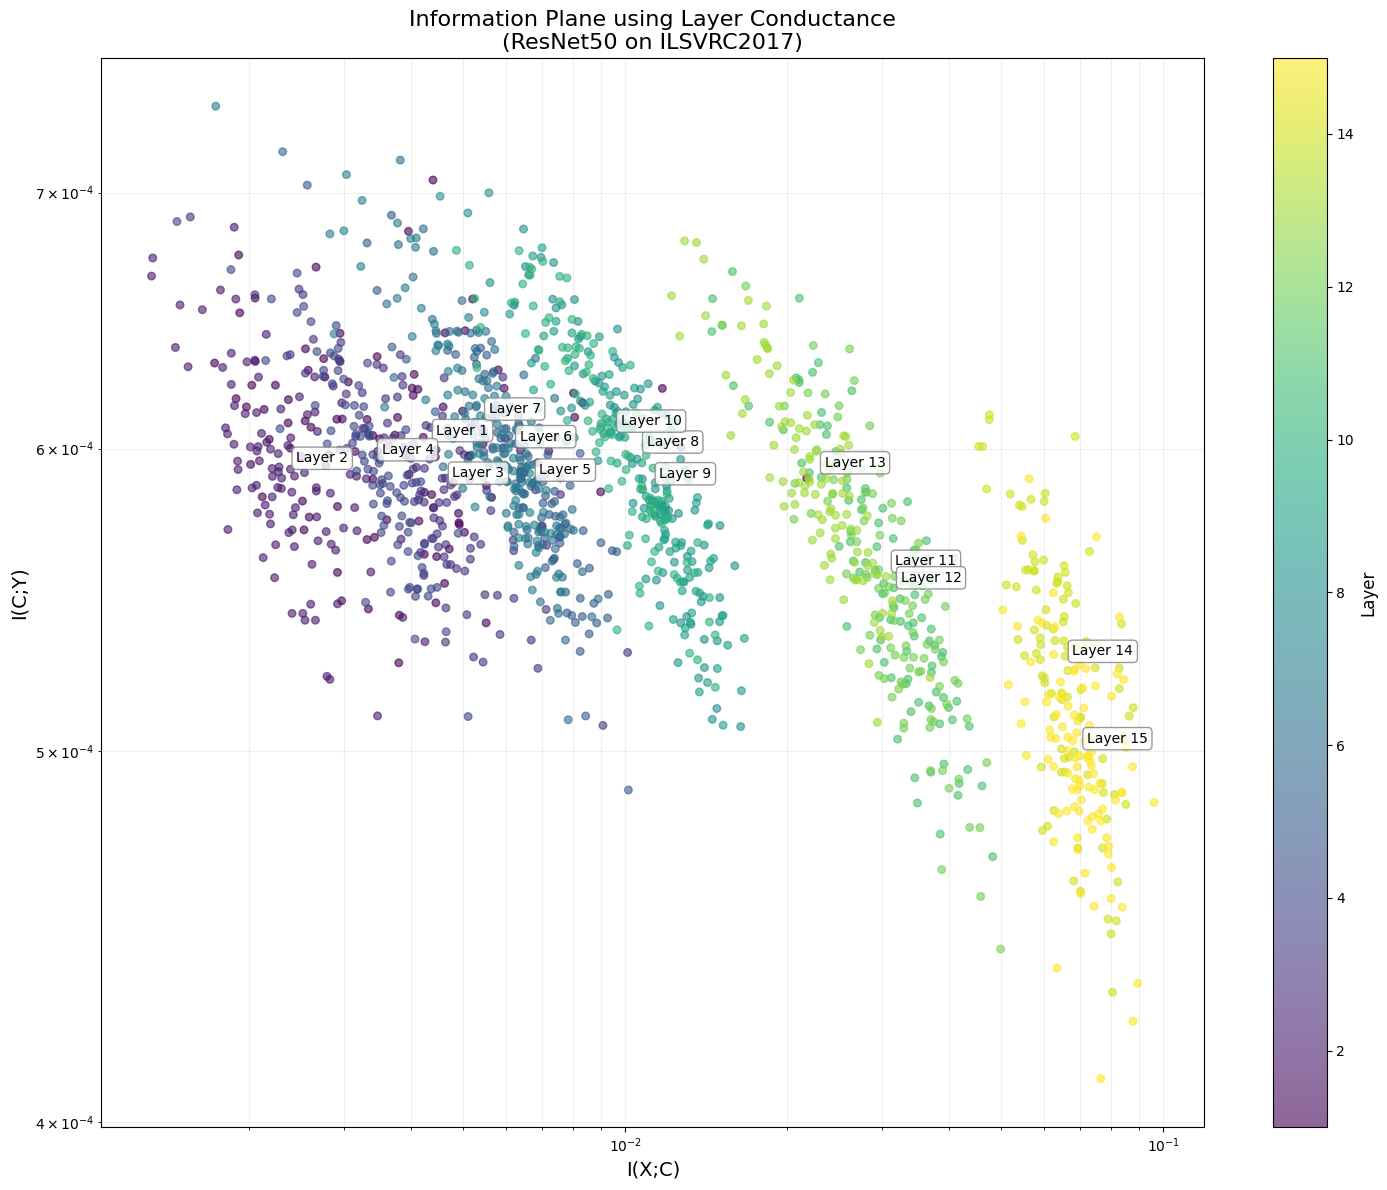

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude the last layer's results
# mi_x_t = mi_x_t[:-1]  # NO NEED TO EXCLUDE NOW 
# mi_t_y = mi_t_y[:-1]  # NO NEED TO EXCLUDE NOW

# Prepare data for plotting (adjusted to exclude last layer)
all_mi_x_t = [item for sublist in mi_x_t for item in sublist]
all_mi_t_y = [item for sublist in mi_t_y for item in sublist]

# Create labels starting at 1, but only for the included layers
layer_labels = [f"Layer {i}" for i in range(1, len(mi_x_t) + 1)] 

# Adjusted layer indices for plotting
all_layers = [layer for layer in range(1, len(layer_labels) + 1) for _ in range(num_samples)]

# Create the figure
plt.figure(figsize=(15, 12))

# Plot all points
scatter = plt.scatter(all_mi_x_t, all_mi_t_y, c=all_layers, cmap='viridis', s=30, alpha=0.6)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Layer', fontsize=12)

# Configure axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('I(X;C)', fontsize=14)
plt.ylabel('I(C;Y)', fontsize=14)
plt.title('Information Plane using Layer Conductance\n(ResNet50 on ILSVRC2017)', fontsize=16)

# Add a grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add annotations for each layer (adjusted to exclude last layer and start from 1)
for layer in range(1, len(mi_x_t) + 1):  # Include all layers up to 15
    layer_mi_x_t = mi_x_t[layer - 1]
    layer_mi_t_y = mi_t_y[layer - 1]
    mean_x = np.mean(layer_mi_x_t)
    mean_y = np.mean(layer_mi_t_y)
    plt.annotate(f'Layer {layer}', (mean_x, mean_y), xytext=(5, 5),
                 textcoords='offset points', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()


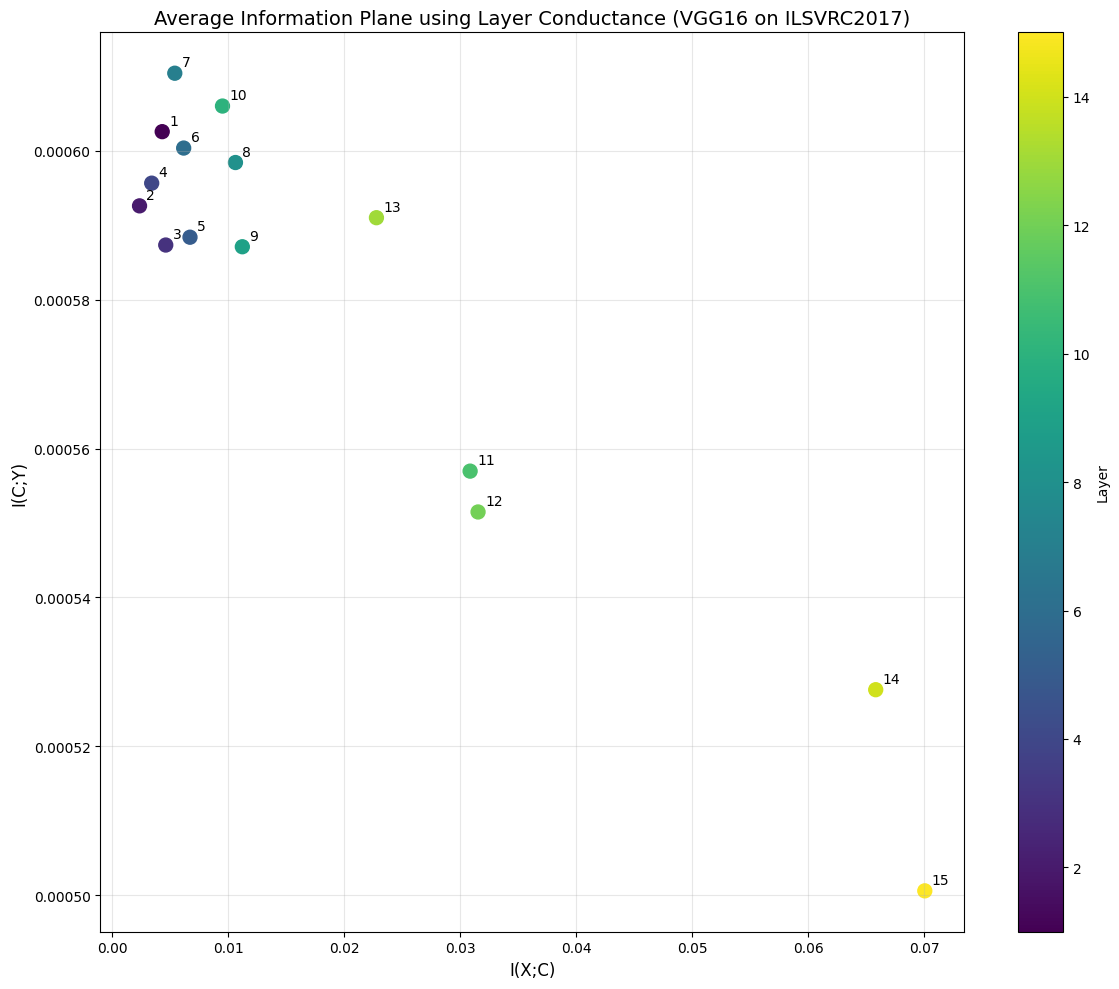

In [8]:
# Plot average information plane
avg_mi_x_t = [np.mean(layer_mi) for layer_mi in mi_x_t]
avg_mi_t_y = [np.mean(layer_mi) for layer_mi in mi_t_y]

# Adjust layer indices for plotting (start from 1 and exclude the last)
layers = list(range(1, len(avg_mi_x_t) + 1)) 

plt.figure(figsize=(12, 10))
scatter = plt.scatter(avg_mi_x_t, avg_mi_t_y, c=layers, cmap='viridis', s=100)
plt.colorbar(scatter, label='Layer')

# Annotate with correct layer numbers starting from 1
for i, layer in enumerate(layers):
    plt.annotate(str(layer), (avg_mi_x_t[i], avg_mi_t_y[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('I(X;C)', fontsize=12)
plt.ylabel('I(C;Y)', fontsize=12)
plt.title('Average Information Plane using Layer Conductance (VGG16 on ILSVRC2017)', fontsize=14)  # Updated title
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

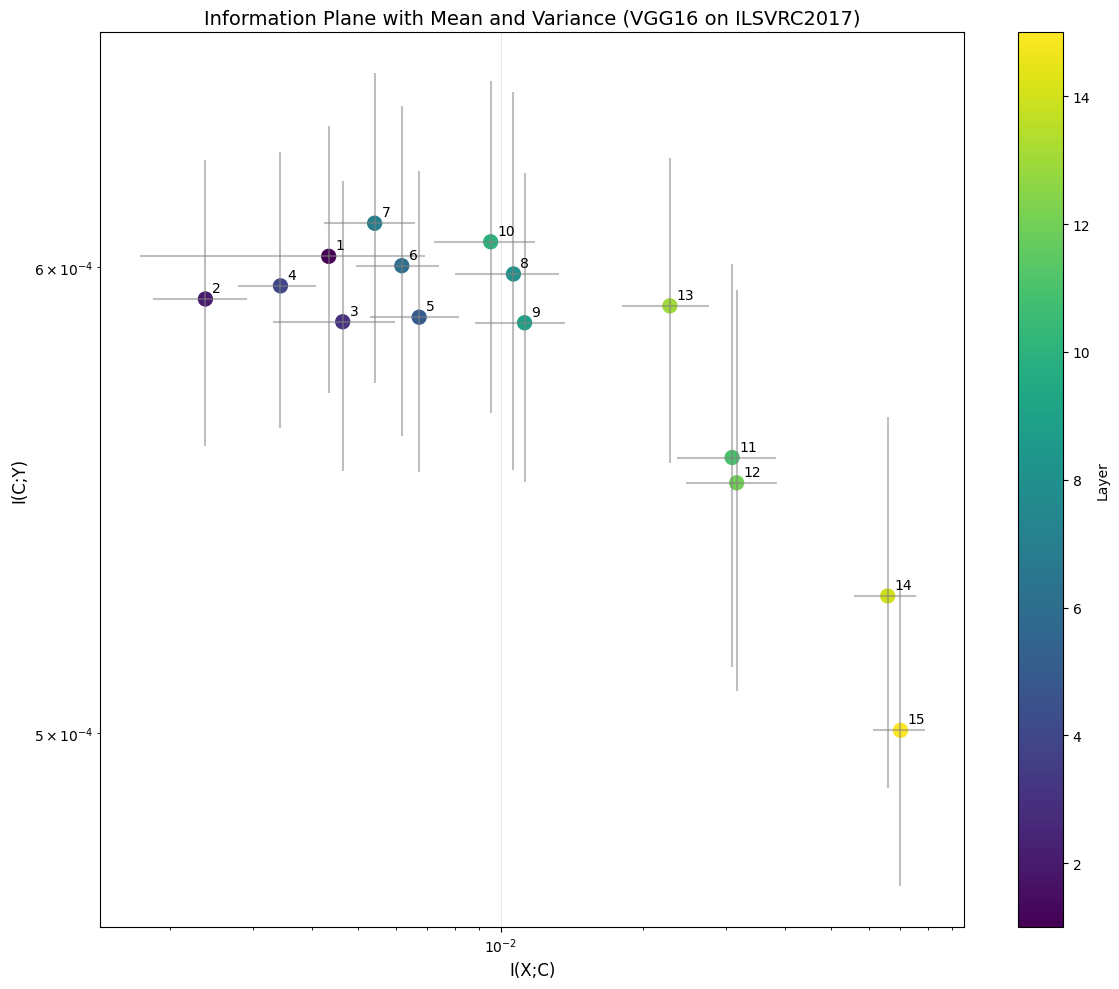

In [10]:
# Calculate mean and standard deviation for each layer (excluding the last)
mean_mi_x_t = np.array([np.mean(layer_mi) for layer_mi in mi_x_t])
mean_mi_t_y = np.array([np.mean(layer_mi) for layer_mi in mi_t_y])
std_mi_x_t = np.array([np.std(layer_mi) for layer_mi in mi_x_t])
std_mi_t_y = np.array([np.std(layer_mi) for layer_mi in mi_t_y])

# Adjust layer indices for plotting (start from 1, exclude the last)
layers = list(range(1, len(mean_mi_x_t) + 1)) 

plt.figure(figsize=(12, 10))
plt.xscale('log') 
plt.yscale('log')
# Plot error bars
plt.errorbar(mean_mi_x_t, mean_mi_t_y, xerr=std_mi_x_t, yerr=std_mi_t_y, fmt='none', ecolor='gray', alpha=0.5)

# Plot scatter points
scatter = plt.scatter(mean_mi_x_t, mean_mi_t_y, c=layers, cmap='viridis', s=100)
plt.colorbar(scatter, label='Layer')

# Annotate points with layer numbers (adjusted for starting from 1)
for i, layer in enumerate(layers):
    plt.annotate(f'{layer}', (mean_mi_x_t[i], mean_mi_t_y[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('I(X;C)', fontsize=12)
plt.ylabel('I(C;Y)', fontsize=12)
plt.title('Information Plane with Mean and Variance (VGG16 on ILSVRC2017)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

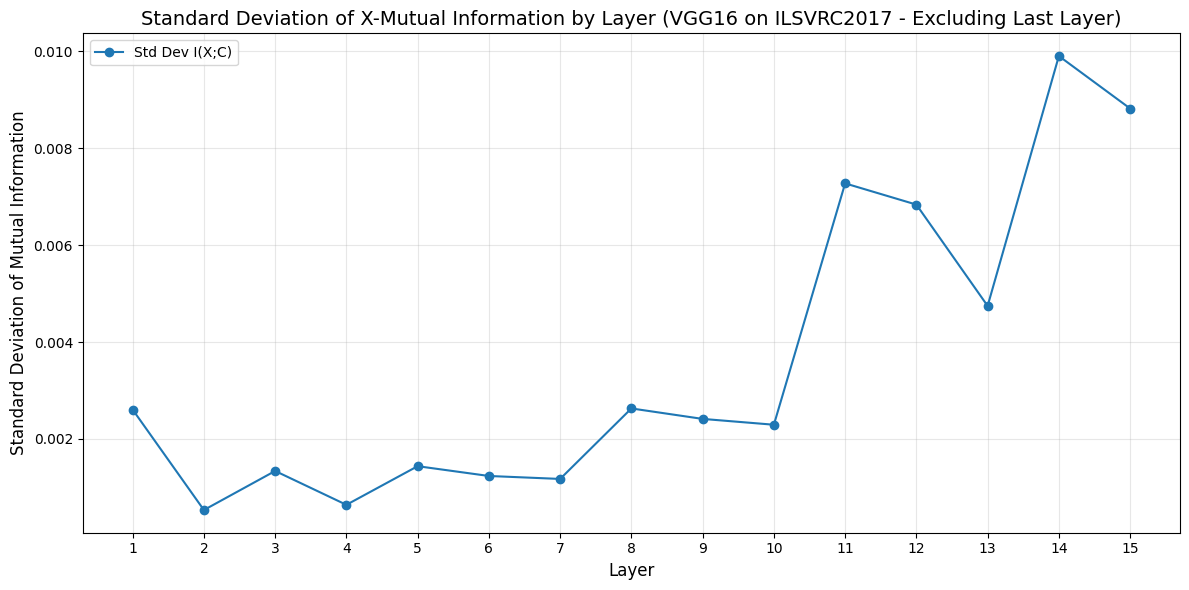

In [13]:
# Calculate mean and standard deviation for each layer (excluding the last)
mean_mi_x_t = np.array([np.mean(layer_mi) for layer_mi in mi_x_t])
mean_mi_t_y = np.array([np.mean(layer_mi) for layer_mi in mi_t_y])
std_mi_x_t = np.array([np.std(layer_mi) for layer_mi in mi_x_t])
std_mi_t_y = np.array([np.std(layer_mi) for layer_mi in mi_t_y])

# Adjust layer indices for plotting (start from 1, exclude the last)
layers = list(range(1, len(mean_mi_x_t) + 1)) 

# Create the new figure for standard deviation plot
plt.figure(figsize=(12, 6))

# Plot standard deviation of I(X;T)
plt.plot(layers, std_mi_x_t, label='Std Dev I(X;C)', marker='o')

plt.xlabel('Layer', fontsize=12)
plt.ylabel('Standard Deviation of Mutual Information', fontsize=12)
plt.title('Standard Deviation of X-Mutual Information by Layer (VGG16 on ILSVRC2017 - Excluding Last Layer)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(layers)
plt.tight_layout()
plt.show()

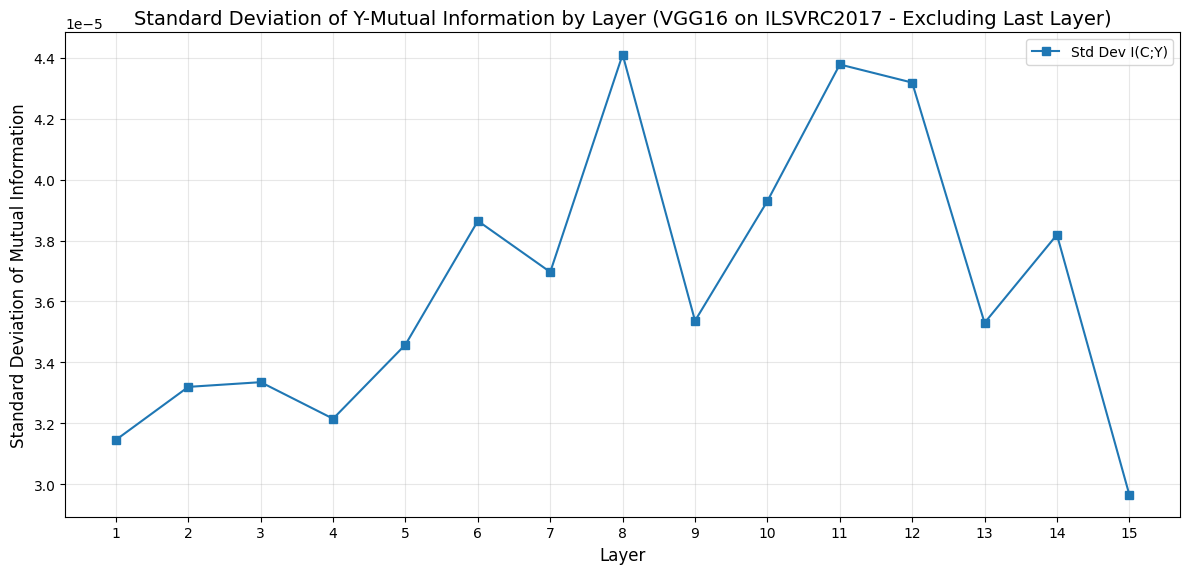

In [14]:
# Calculate mean and standard deviation for each layer (excluding the last)
mean_mi_x_t = np.array([np.mean(layer_mi) for layer_mi in mi_x_t])
mean_mi_t_y = np.array([np.mean(layer_mi) for layer_mi in mi_t_y])
std_mi_x_t = np.array([np.std(layer_mi) for layer_mi in mi_x_t])
std_mi_t_y = np.array([np.std(layer_mi) for layer_mi in mi_t_y])

# Adjust layer indices for plotting (start from 1, exclude the last)
layers = list(range(1, len(mean_mi_t_y) + 1)) 

# Create the new figure for standard deviation plot
plt.figure(figsize=(12, 6))

# Plot standard deviation of I(T;Y)
plt.plot(layers, std_mi_t_y, label='Std Dev I(C;Y)', marker='s')

plt.xlabel('Layer', fontsize=12)
plt.ylabel('Standard Deviation of Mutual Information', fontsize=12)
plt.title('Standard Deviation of Y-Mutual Information by Layer (VGG16 on ILSVRC2017 - Excluding Last Layer)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(layers)
plt.tight_layout()
plt.show()